# Fuzzy edge detector

This tutorial shows how fuzzy logic can be applied to image processing. It showcases how
`FuzzyLogic.jl` seamlessly composes with common Julia image processing libraries and works
out-of-the box.

This tutorial builds a fuzzy edge detector and it is inspired from the matlab tutorial
available [here](https://www.mathworks.com/help/fuzzy/fuzzy-logic-image-processing.html).

DOWNLOAD_NOTE

## Introduction

We want to design an edge detector. That is, a function that takes an image as input and finds
the edges in the image.
Our function should produce a new image, with edges highlighted in black and flat areas in white.

First, let's load the image processing tools we need in this tutorial.

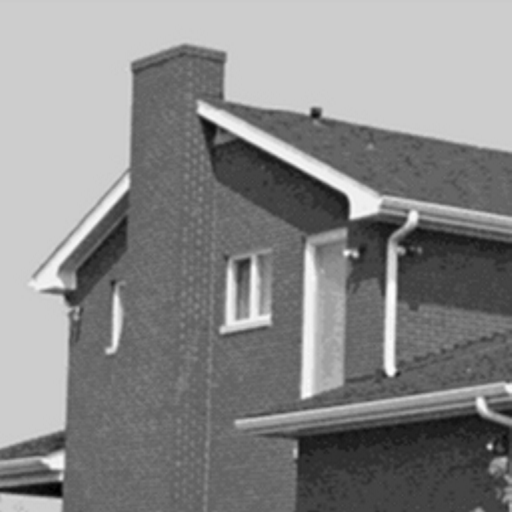

In [1]:
using TestImages, ImageFiltering, ImageShow, ImageCore

img = Gray.(testimage("house"))

Next, we need to model our problem. When we cross an edge, we have a transition from a clearly delimited area to another.
Hence, a pixel is on an edge if moving in its neighborhood we see some change in intensity.
If, on the other hand, in the pixel neighborhood there is no change, then it belongs to a flat area.

Hence, to detect edges we need to compute the gradient of the image at each pixel.
This can be done using `imgradients` from [ImageFiltering](https://github.com/JuliaImages/ImageFiltering.jl).
This function will return two images, one containg the gradient x-component at each pixel, and one containing the y-component at each pixel.
For better visualization, these gradient images are renormalized so that their maximum in absolute value is $1$.

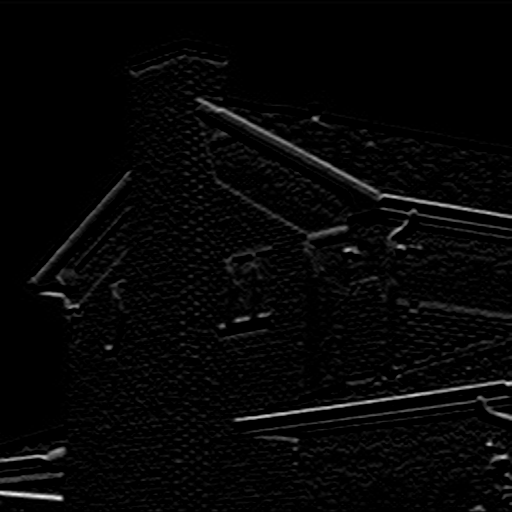

In [2]:
img_y, img_x = imgradients(img, KernelFactors.sobel)

img_y /= Float64(maximum(abs.(img_y)))
img_x /= Float64(maximum(abs.(img_x)))

img_y

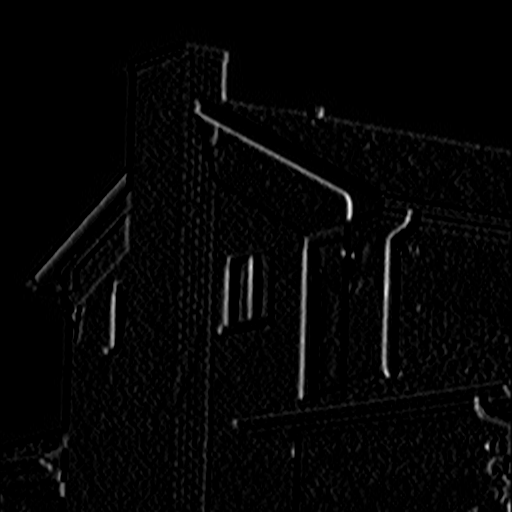

In [3]:
img_x

## Fuzzy system design

Now we want to design a fuzzy system that takes as input the gradient x- and y- components and produces as output the intensity of the new image.
Particularly, in the output image we want to plot flat areas in white (intensity close to $1$) and edges in black (intensity close to $0$).

Based on our previous discussion, a pixel belongs to a flat area if it has zero gradient (i.e. both x- and y-components are zero).
If the gradient is non-zero (either x- or y-component is non-zero) then it belongs to an edge.
Hence for our fuzzy edge detector we can use the following rules

- If the gradient x-component is zero and the gradient y-component is zero, then the output intensity is white.
- If the gradient x-component is nonzero or the gradient y-compnent is non-zero, then the output intensity is black.

Hence, for the input, we will use a single membership function `zero`, which is a sharp Gaussian centered at zero.
For the outupt, we have two membership functions, `black` and `white`.
Recalling that a black pixel means intensity zero and a white pixel intensity one, we will use for `black` a linear membership function, that decreases from $1$
to $0$ as the intensity increases. Similarly, for `white` we can use a linear membership function that increases as the intensity increases.

We can now implement and visualize our inference system.

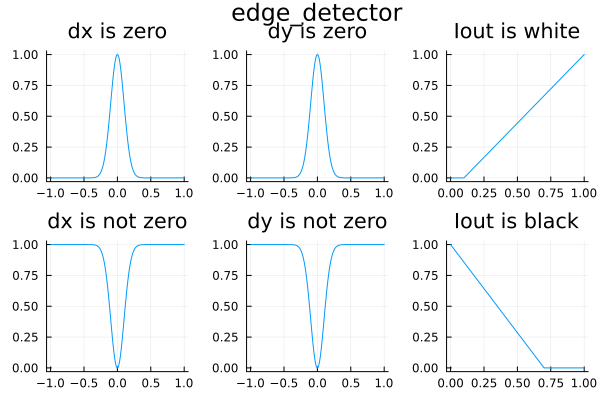

In [4]:
using FuzzyLogic, Plots

fis = @mamfis function edge_detector(dx, dy)::Iout
    dx := begin
        domain = -1:1
        zero = GaussianMF(0.0, 0.1)
    end

    dy := begin
        domain = -1:1
        zero = GaussianMF(0.0, 0.1)
    end

    Iout := begin
        domain = 0:1
        black = LinearMF(0.7, 0.0)
        white = LinearMF(0.1, 1.0)
    end

    dx == zero && dy == zero --> Iout == white
    dx != zero || dy != zero --> Iout == black
end
plot(fis)

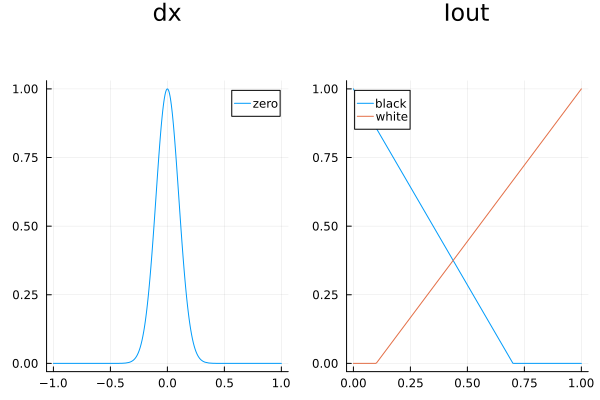

In [5]:
plot(plot(fis, :dx), plot(fis, :Iout), layout = (1, 2))

We are now ready to apply our fuzzy edge detector to the input image.
We will create a new image `Iout` and assign to each pixel the intensity value computed with our fuzzy system.

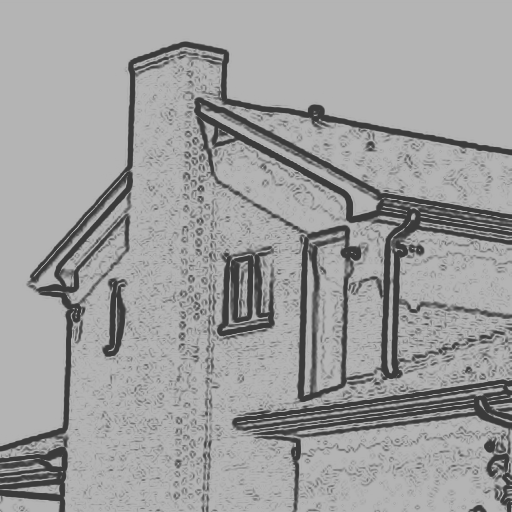

In [6]:
Iout = copy(img)

for idx in eachindex(Iout)
    Iout[idx] = fis(dx = img_x[idx], dy = img_y[idx])[:Iout]
end
Iout